Email Table Sample:
   email_id   email_text email_version  hour    weekday user_country  user_past_purchases
0     85120  short_email  personalized     2     Sunday           US                    5
1    966622   long_email  personalized    12     Sunday           UK                    2
2    777221   long_email  personalized    11  Wednesday           US                    2
3    493711  short_email       generic     6     Monday           UK                    1
4    106887   long_email       generic    14     Monday           US                    6

Email Opened Table Sample:
   email_id
0    284534
1    609056
2    220820
3    905936
4    164034

Link Clicked Table Sample:
   email_id
0    609056
1    870980
2    935124
3    158501
4    177561

Missing values in email_df:
email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
dtype: int64

Email dataset shape: (

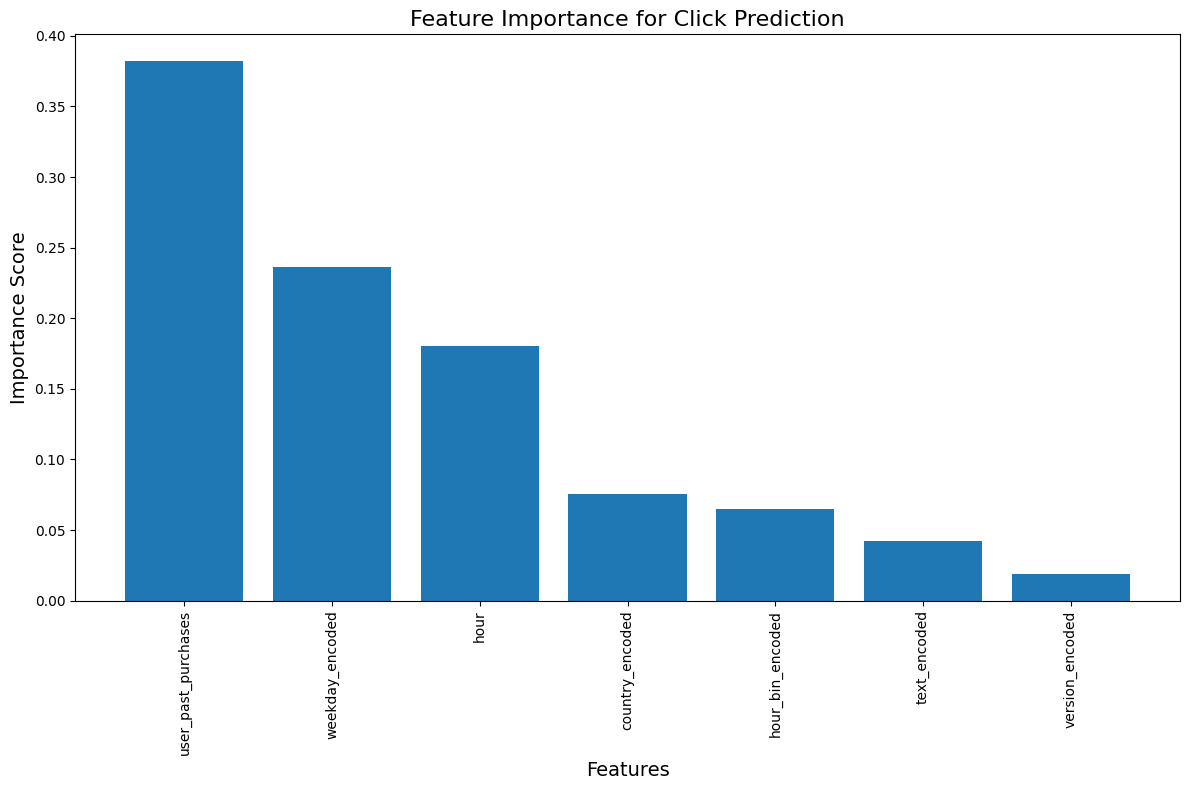

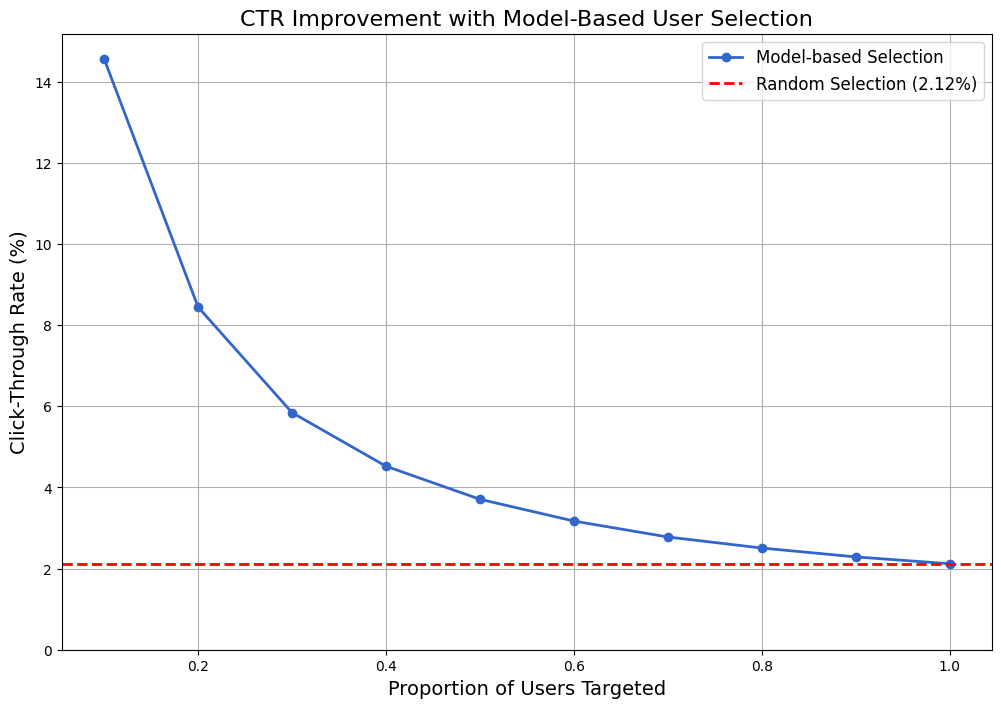

Baseline CTR (random selection): 2.12%
CTR when targeting top 10% users: 14.56% (Improvement: 6.87x)
CTR when targeting top 20% users: 8.45% (Improvement: 3.99x)
CTR when targeting top 50% users: 3.71% (Improvement: 1.75x)

--- Performance by Email Length email_text ---
Highest open rate: short_email (11.59%)
Lowest open rate: long_email (9.12%)
Highest click rate: short_email (2.39%)
Lowest click rate: long_email (1.85%)


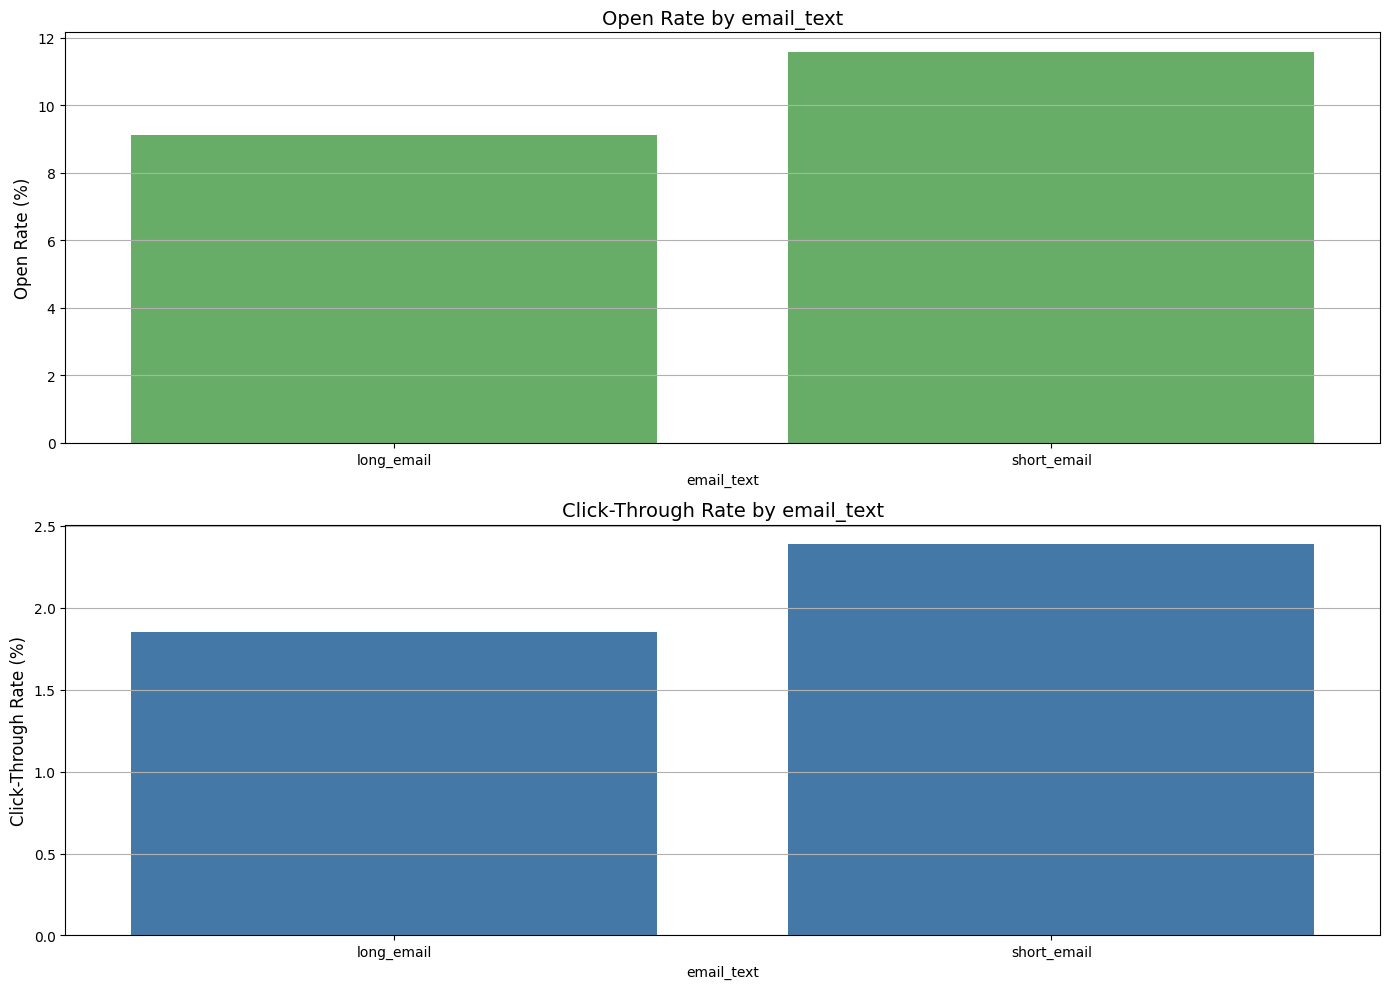


--- Performance by Email Personalization email_version ---
Highest open rate: personalized (12.78%)
Lowest open rate: generic (7.93%)
Highest click rate: personalized (2.73%)
Lowest click rate: generic (1.51%)


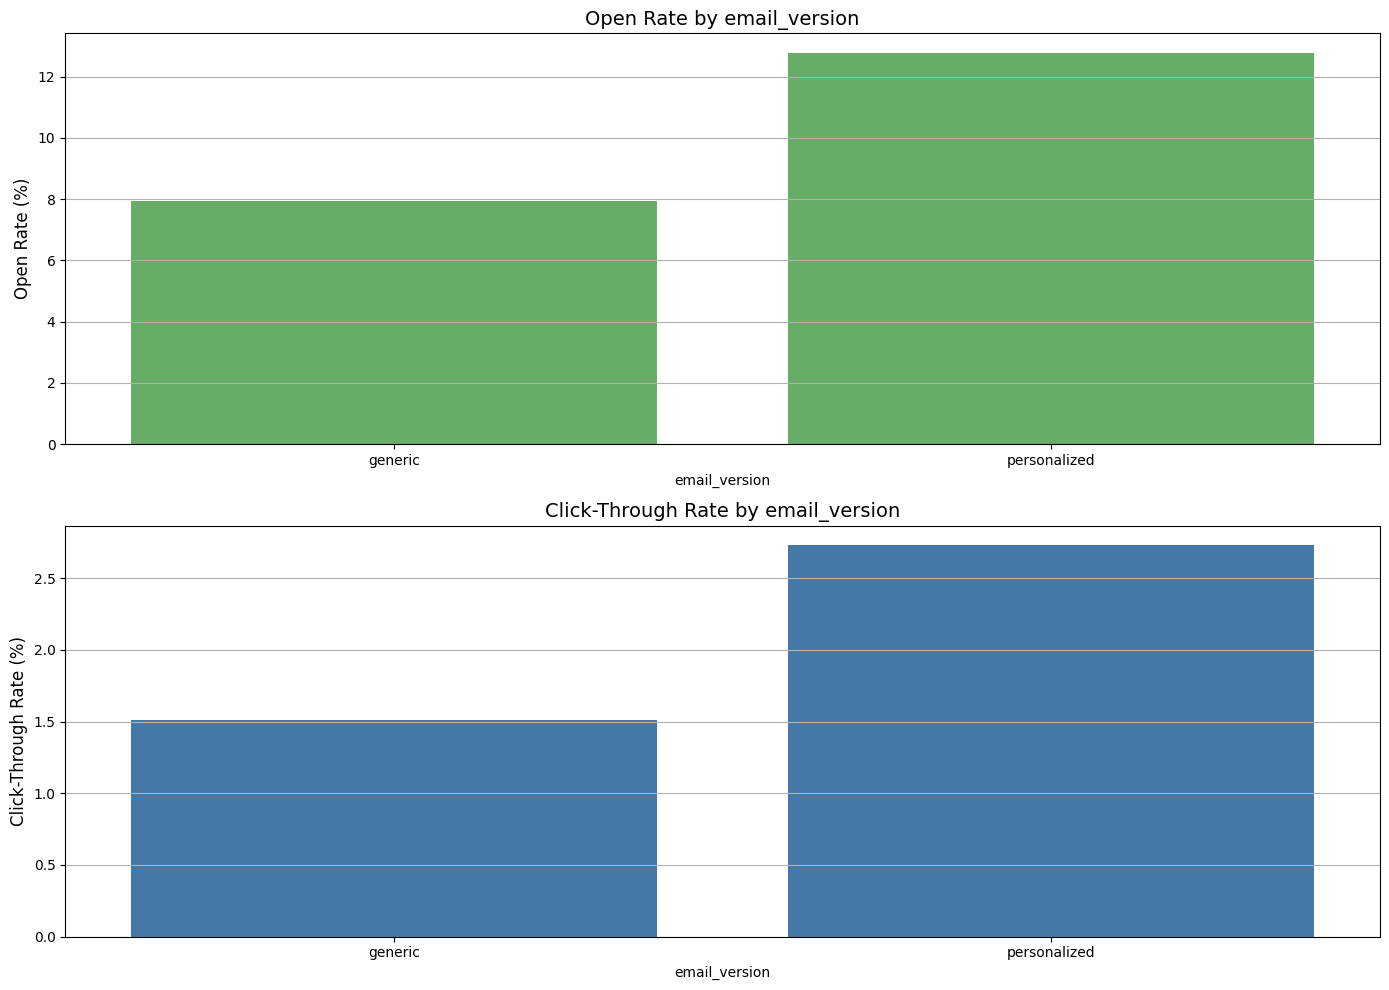


--- Performance by Time of Day (2-Hour Intervals) hour_bin ---
Highest open rate: 8-10 (12.90%)
Lowest open rate: 20-22 (5.98%)
Highest click rate: 22-24 (3.74%)
Lowest click rate: 20-22 (1.23%)


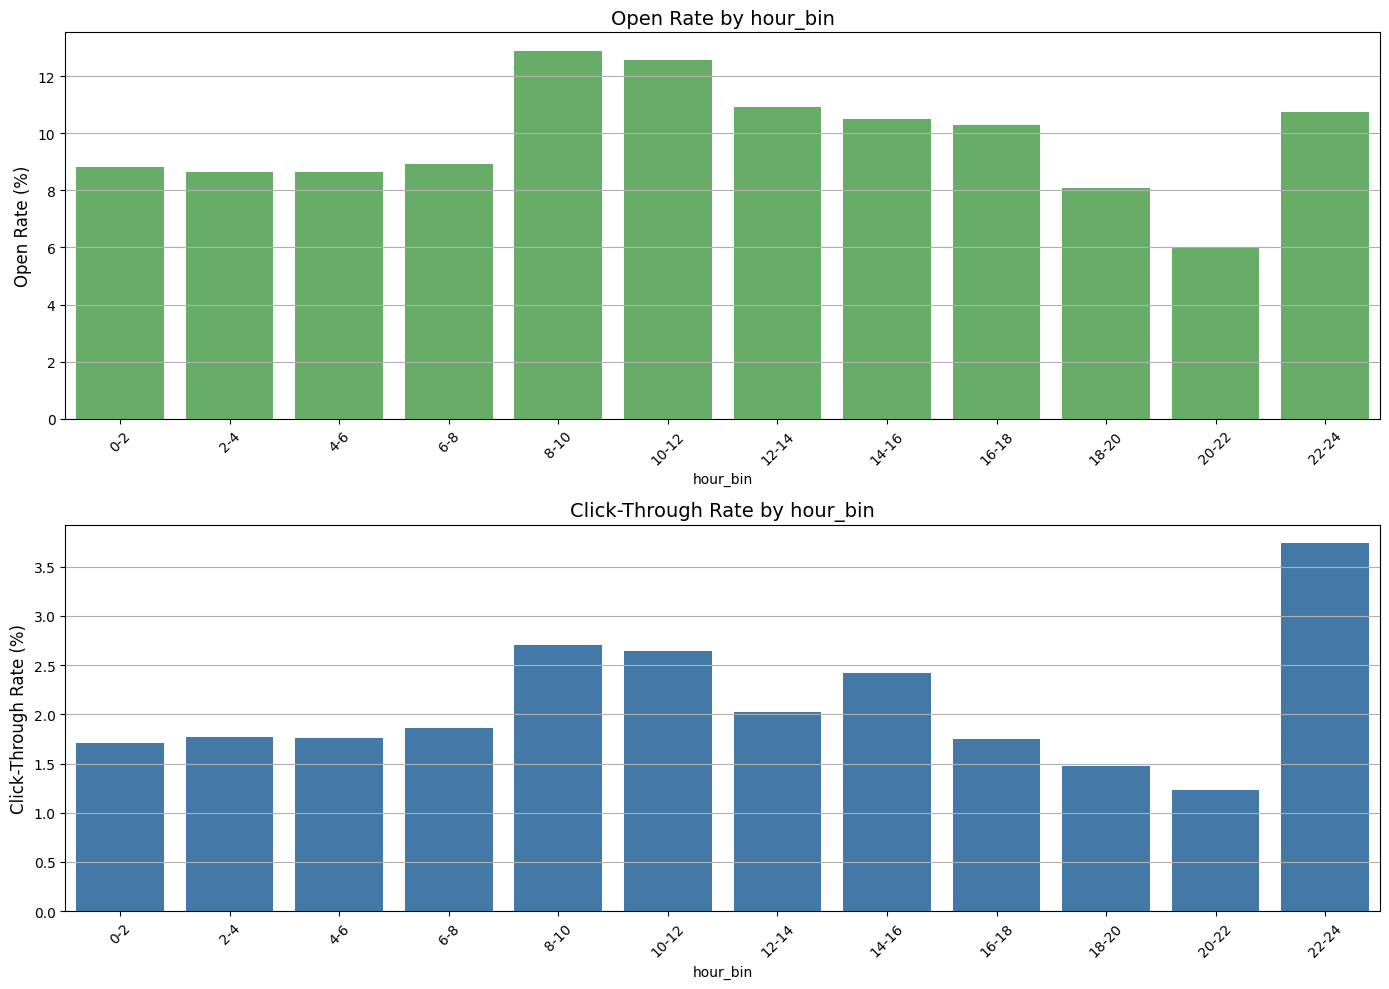


--- Performance by Day of Week weekday ---
Highest open rate: Tuesday (12.05%)
Lowest open rate: Friday (7.41%)
Highest click rate: Wednesday (2.76%)
Lowest click rate: Friday (1.40%)


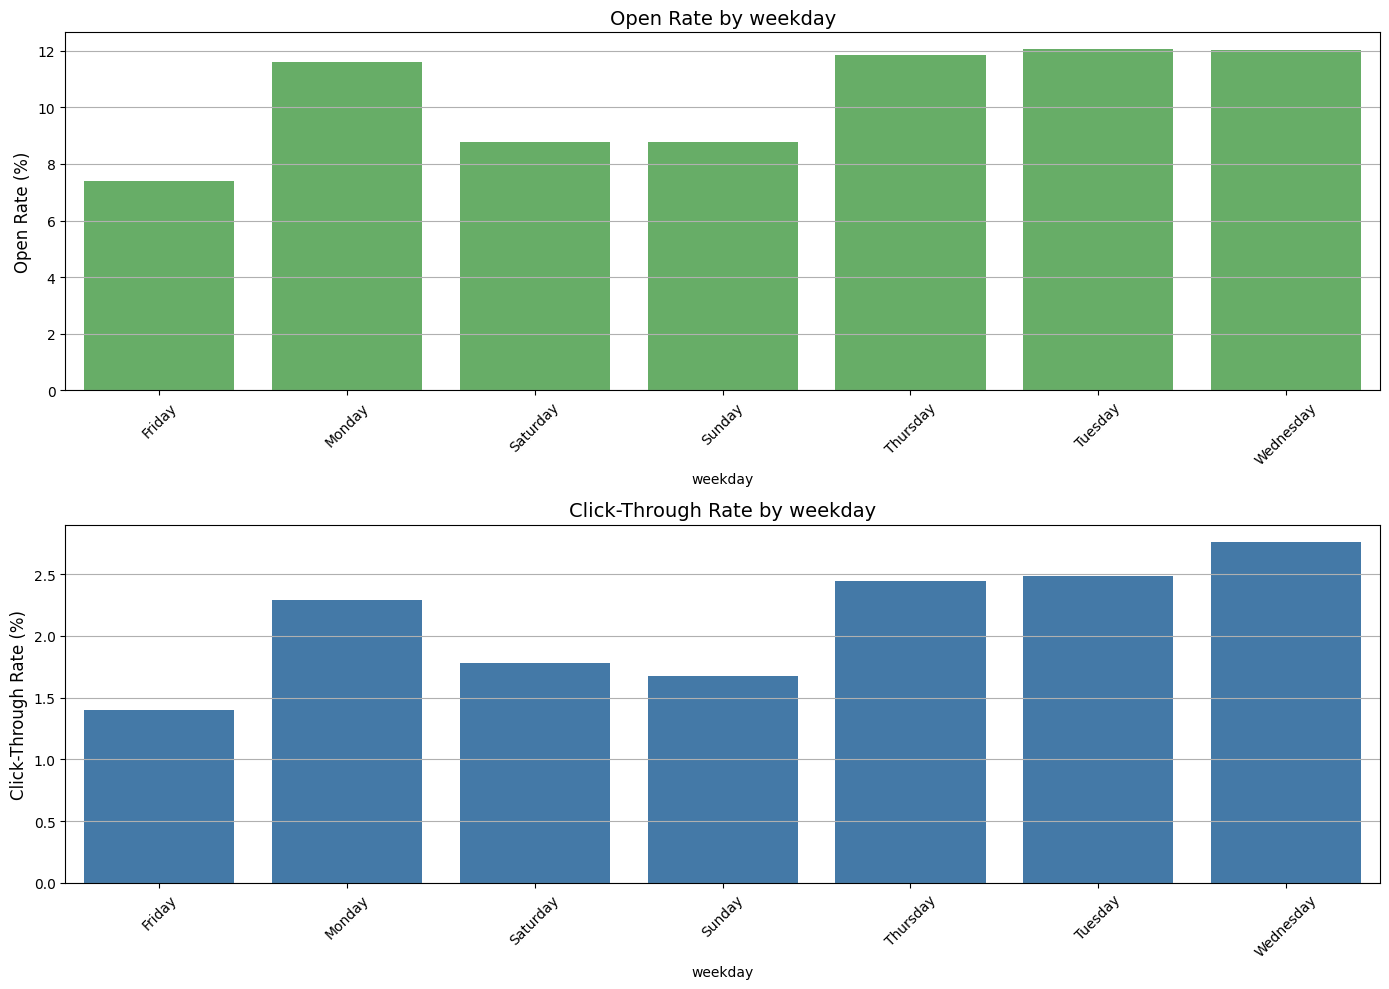


--- Performance by User Country user_country ---
Highest open rate: UK (12.02%)
Lowest open rate: ES (3.91%)
Highest click rate: UK (2.47%)
Lowest click rate: FR (0.80%)


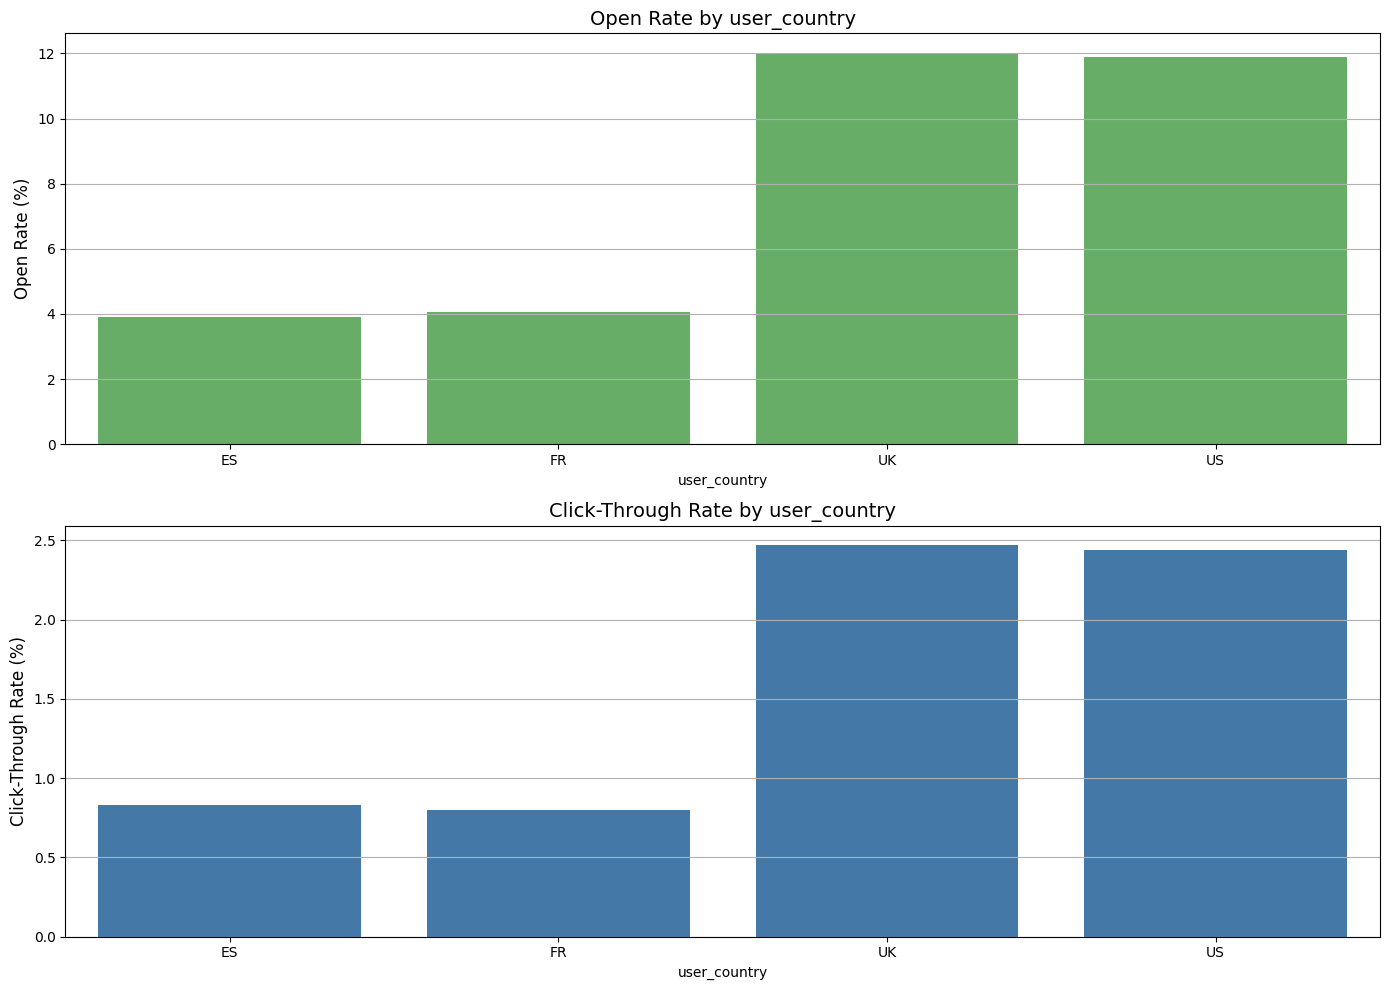


--- Performance by Purchase History purchase_category ---
Highest open rate: 10+ purchases (15.75%)
Lowest open rate: 0 purchases (3.83%)
Highest click rate: 10+ purchases (6.90%)
Lowest click rate: 0 purchases (0.05%)


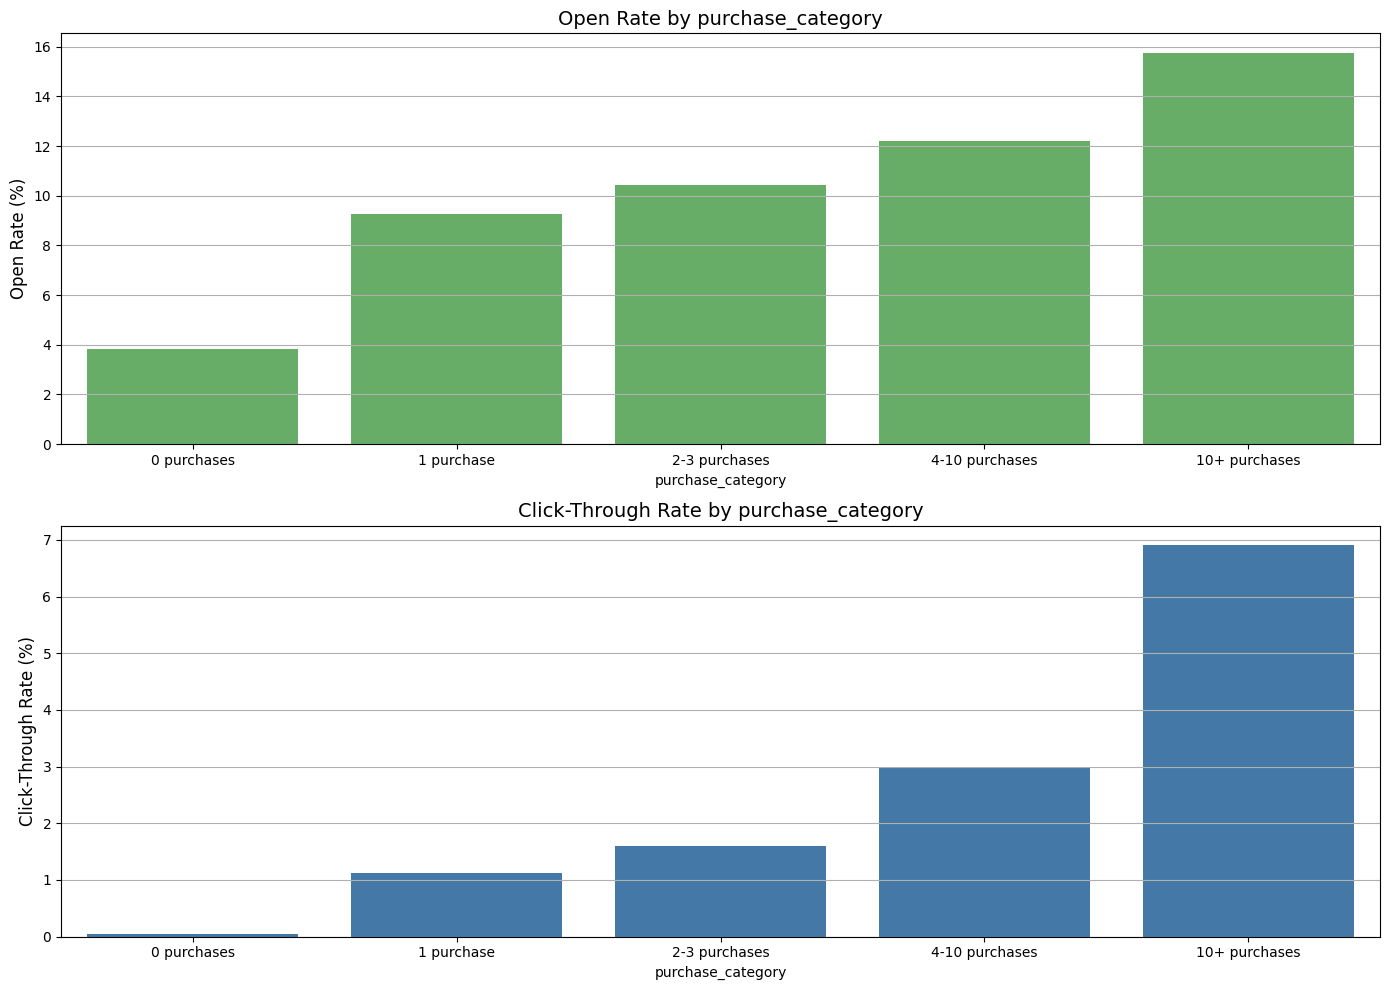

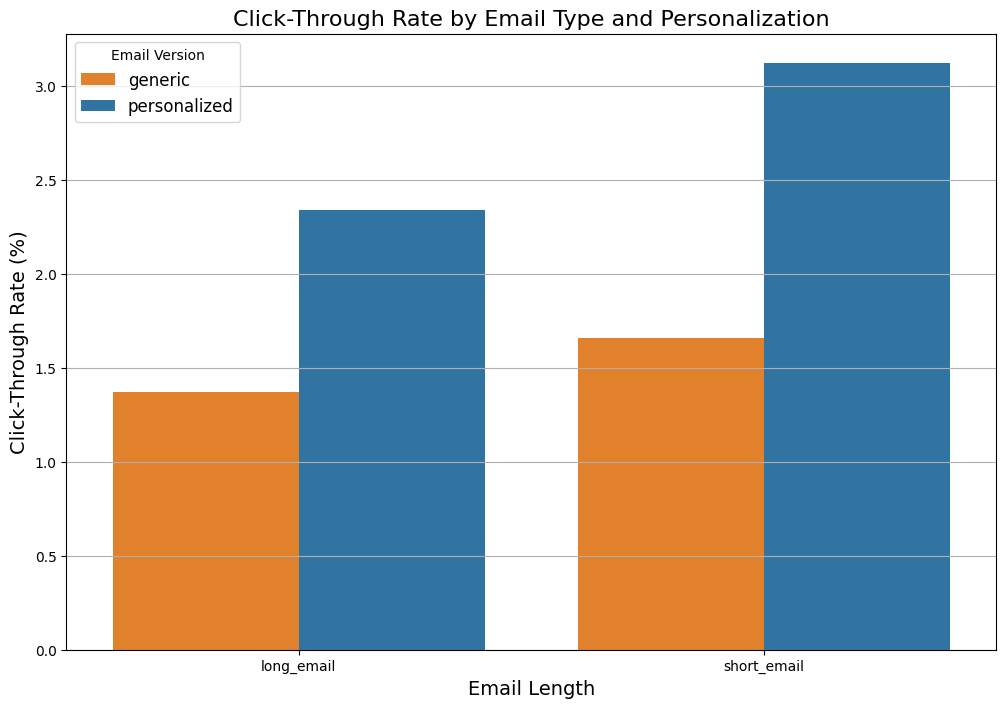


--- Performance by Email Type & Personalization Combination ---
Best combination: short_email & personalized (3.12% CTR)
Worst combination: long_email & generic (1.37% CTR)


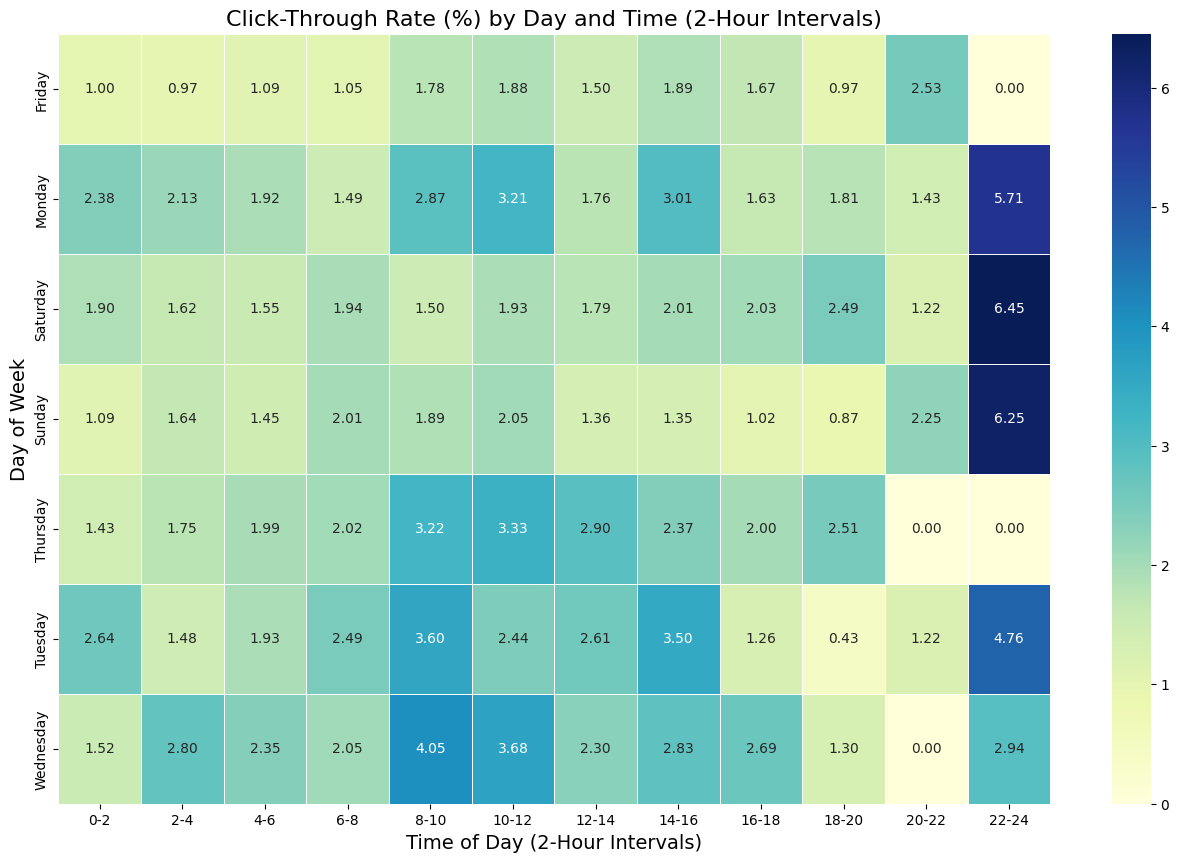


--- Best and Worst Timing for Emails ---
Best timing: Saturday at 22-24 hours (6.45% CTR)
Worst timing: Friday at 22-24 hours (0.00% CTR)


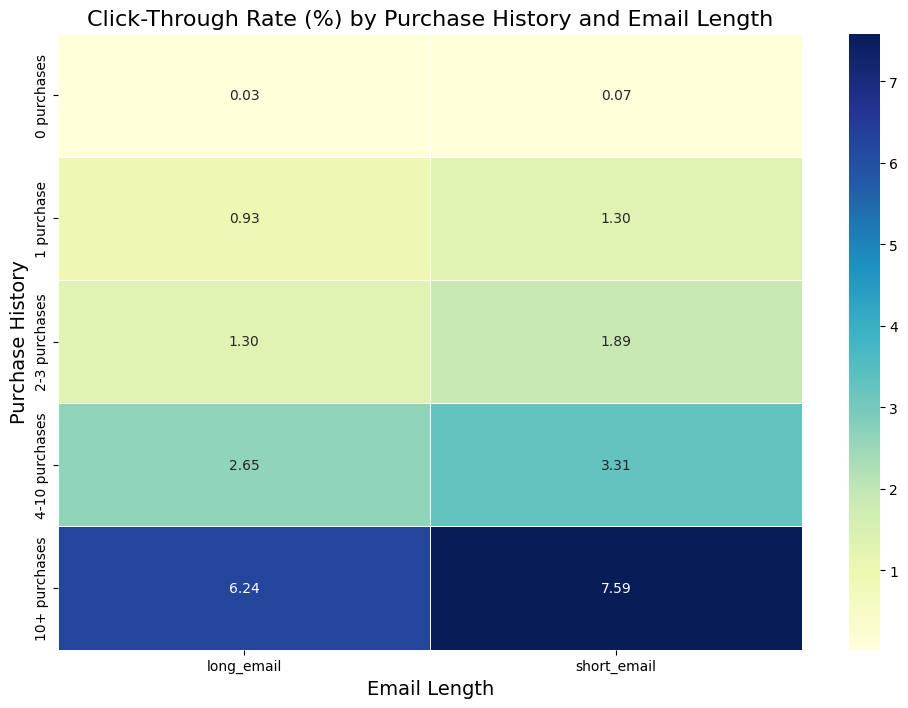

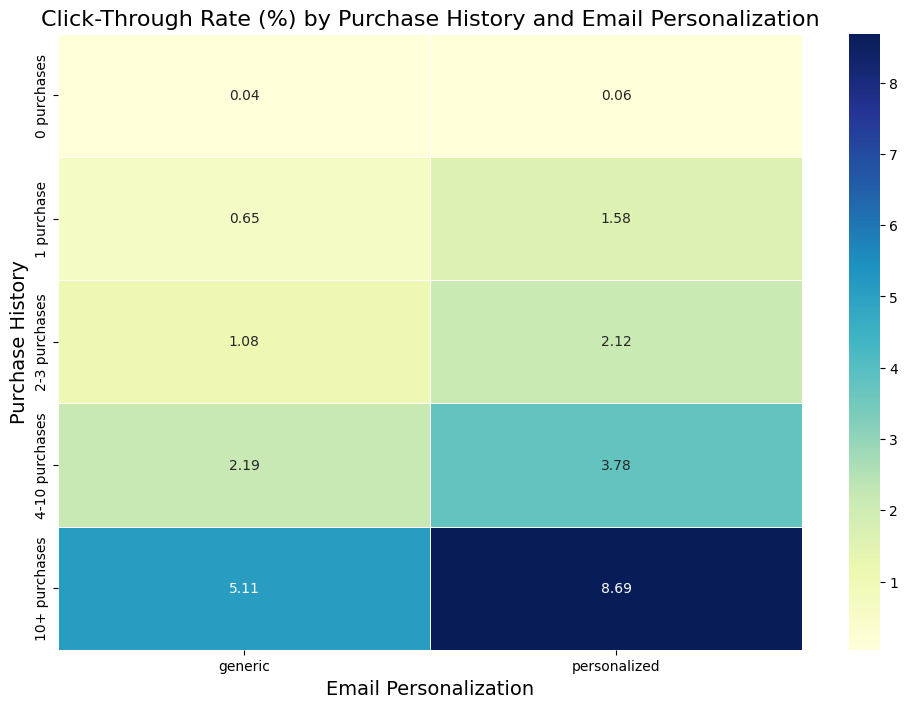

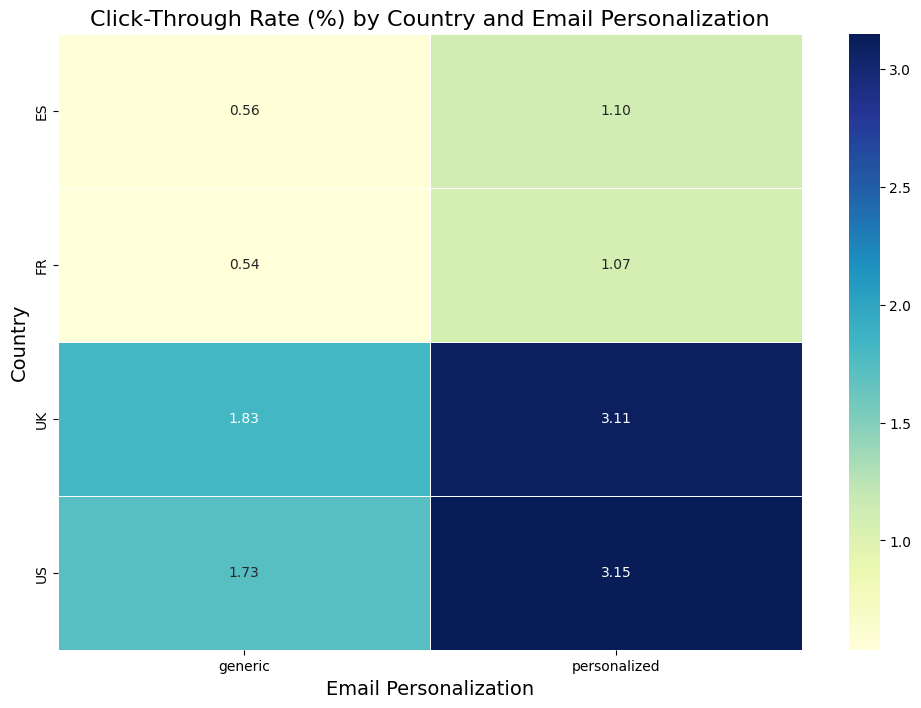

1. Overall email campaign performance:
   - Open rate: 10.35%
   - Click-through rate: 2.12%
   - Click-to-open rate: 20.48%

2. Best performing segments:
   - Email length: short_email with 2.39% CTR
   - Email personalization: personalized with 2.73% CTR
   - Time of day: 22-24 with 3.74% CTR
   - Day of week: Wednesday with 2.76% CTR
   - Country: UK with 2.47% CTR
   - Purchase history: 10+ purchases with 6.90% CTR

3. Model performance:
   - Our model could improve CTR by up to 6.87x by targeting the most responsive users
   - Most important factors for predicting clicks are: user_past_purchases, weekday_encoded, hour

4. Best email strategy:
   - Best email combination: short_email & personalized
   - Best timing: Saturday at 22-24 hours
   - Target audience: 10+ purchases in UK


In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Load the datasets
# Load email data
email_df = pd.read_csv('email_table.csv')
opened_df = pd.read_csv('email_opened_table.csv')
clicked_df = pd.read_csv('link_clicked_table.csv')

# Display the first few rows of each dataset to understand their structure
print("Email Table Sample:")
print(email_df.head())
print("\nEmail Opened Table Sample:")
print(opened_df.head())
print("\nLink Clicked Table Sample:")
print(clicked_df.head())

# Check for missing values
print("\nMissing values in email_df:")
print(email_df.isnull().sum())

# Get basic information about the datasets
print("\nEmail dataset shape:", email_df.shape)
print("Opened emails dataset shape:", opened_df.shape)
print("Clicked links dataset shape:", clicked_df.shape)

# Create binary flags for opened and clicked
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

# Create 2-hour intervals for time analysis
email_df['hour_bin'] = pd.cut(
    email_df['hour'],
    bins=range(0, 25, 2),  # 0-2, 2-4, 4-6, ..., 22-24
    labels=[f"{i}-{i+2}" for i in range(0, 24, 2)],
    include_lowest=True
)

# checking the  What percentage of users opened the email and clicked the link
total_emails = len(email_df)
opened_count = email_df['opened'].sum()
clicked_count = email_df['clicked'].sum()

opened_pct = opened_count / total_emails * 100
clicked_pct = clicked_count / total_emails * 100
click_to_open_rate = clicked_count / opened_count * 100 if opened_count > 0 else 0


print(f"Total emails sent: {total_emails}")
print(f"Number of emails opened: {opened_count} ({opened_pct:.2f}%)")
print(f"Number of emails clicked: {clicked_count} ({clicked_pct:.2f}%)")
print(f"Click-to-Open Rate: {click_to_open_rate:.2f}%")

# Create features for modeling
# Encode categorical variables
le_country = LabelEncoder()
le_weekday = LabelEncoder()
le_email_text = LabelEncoder()
le_email_version = LabelEncoder()
le_hour_bin = LabelEncoder()

email_df['country_encoded'] = le_country.fit_transform(email_df['user_country'])
email_df['weekday_encoded'] = le_weekday.fit_transform(email_df['weekday'])
email_df['text_encoded'] = le_email_text.fit_transform(email_df['email_text'])
email_df['version_encoded'] = le_email_version.fit_transform(email_df['email_version'])
email_df['hour_bin_encoded'] = le_hour_bin.fit_transform(email_df['hour_bin'])

# Prepare features for modeling
features = ['text_encoded', 'version_encoded', 'hour', 'weekday_encoded',
            'country_encoded', 'user_past_purchases', 'hour_bin_encoded']
X = email_df[features]
y = email_df['clicked']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
print("\n----- Question 2: Model Building Results -----")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.title('Feature Importance for Click Prediction', fontsize=16)
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance Score', fontsize=14)
plt.tight_layout()
plt.show()

# Sort by predicted probability of clicking
email_df['click_probability'] = rf_model.predict_proba(X)[:, 1]
email_df_sorted = email_df.sort_values(by='click_probability', ascending=False)

# Calculate cumulative CTR for different percentages of top users
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cumulative_ctrs = []

for p in percentages:
    top_n = int(total_emails * p)
    top_users = email_df_sorted.head(top_n)
    ctr = top_users['clicked'].sum() / len(top_users) * 100
    cumulative_ctrs.append(ctr)

# Random CTR (baseline)
random_ctr = clicked_pct

# Plot improvement curve
plt.figure(figsize=(12, 8))
plt.plot(percentages, cumulative_ctrs, marker='o', linewidth=2, color='#3366cc', label='Model-based Selection')
plt.axhline(y=random_ctr, color='r', linestyle='--', linewidth=2, label=f'Random Selection ({random_ctr:.2f}%)')
plt.xlabel('Proportion of Users Targeted', fontsize=14)
plt.ylabel('Click-Through Rate (%)', fontsize=14)
plt.title('CTR Improvement with Model-Based User Selection', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

# Calculate potential improvement
top_10pct_ctr = cumulative_ctrs[0]
top_20pct_ctr = cumulative_ctrs[1]
top_50pct_ctr = cumulative_ctrs[4]

print(f"Baseline CTR (random selection): {random_ctr:.2f}%")
print(f"CTR when targeting top 10% users: {top_10pct_ctr:.2f}% (Improvement: {top_10pct_ctr/random_ctr:.2f}x)")
print(f"CTR when targeting top 20% users: {top_20pct_ctr:.2f}% (Improvement: {top_20pct_ctr/random_ctr:.2f}x)")
print(f"CTR when targeting top 50% users: {top_50pct_ctr:.2f}% (Improvement: {top_50pct_ctr/random_ctr:.2f}x)")

# Create a function to visualize and analyze each categorical feature
def analyze_feature(df, feature_name, title_prefix="Performance by"):
    # Group by the feature and calculate metrics
    feature_perf = df.groupby(feature_name).agg(
        emails_sent=('email_id', 'count'),
        opened=('opened', 'sum'),
        clicked=('clicked', 'sum')
    ).reset_index()

    # Calculate rates
    feature_perf['open_rate'] = feature_perf['opened'] / feature_perf['emails_sent'] * 100
    feature_perf['ctr'] = feature_perf['clicked'] / feature_perf['emails_sent'] * 100
    feature_perf['click_to_open'] = feature_perf['clicked'] / feature_perf['opened'] * 100

    # Sort for finding max and min
    max_open = feature_perf.loc[feature_perf['open_rate'].idxmax()]
    min_open = feature_perf.loc[feature_perf['open_rate'].idxmin()]
    max_click = feature_perf.loc[feature_perf['ctr'].idxmax()]
    min_click = feature_perf.loc[feature_perf['ctr'].idxmin()]

    # Print stats
    print(f"\n--- {title_prefix} {feature_name} ---")
    print(f"Highest open rate: {max_open[feature_name]} ({max_open['open_rate']:.2f}%)")
    print(f"Lowest open rate: {min_open[feature_name]} ({min_open['open_rate']:.2f}%)")
    print(f"Highest click rate: {max_click[feature_name]} ({max_click['ctr']:.2f}%)")
    print(f"Lowest click rate: {min_click[feature_name]} ({min_click['ctr']:.2f}%)")

    # Create visualizations
    plt.figure(figsize=(14, 10))

    # Plot 1: Open Rate
    plt.subplot(2, 1, 1)
    sns.barplot(x=feature_name, y='open_rate', data=feature_perf, color='#5cb85c')
    plt.title(f'Open Rate by {feature_name}', fontsize=14)
    plt.ylabel('Open Rate (%)', fontsize=12)
    plt.xticks(rotation=45 if len(feature_perf) > 5 else 0)
    plt.grid(axis='y')

    # Plot 2: Click Rate
    plt.subplot(2, 1, 2)
    sns.barplot(x=feature_name, y='ctr', data=feature_perf, color='#337ab7')
    plt.title(f'Click-Through Rate by {feature_name}', fontsize=14)
    plt.ylabel('Click-Through Rate (%)', fontsize=12)
    plt.xticks(rotation=45 if len(feature_perf) > 5 else 0)
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

    # Return the dataframe
    return feature_perf

#  purchase categories for better visualization
email_df['purchase_category'] = pd.cut(
    email_df['user_past_purchases'],
    bins=[-1, 0, 1, 3, 10, 100],
    labels=['0 purchases', '1 purchase', '2-3 purchases', '4-10 purchases', '10+ purchases']
)

# Analyze each feature
analyze_feature(email_df, 'email_text', "Performance by Email Length")
analyze_feature(email_df, 'email_version', "Performance by Email Personalization")
analyze_feature(email_df, 'hour_bin', "Performance by Time of Day (2-Hour Intervals)")
analyze_feature(email_df, 'weekday', "Performance by Day of Week")
analyze_feature(email_df, 'user_country', "Performance by User Country")
analyze_feature(email_df, 'purchase_category', "Performance by Purchase History")

# Visualize interaction between email type and personalization
email_type_personalization = email_df.groupby(['email_text', 'email_version']).agg(
    emails_sent=('email_id', 'count'),
    opened=('opened', 'sum'),
    clicked=('clicked', 'sum')
).reset_index()

email_type_personalization['open_rate'] = email_type_personalization['opened'] / email_type_personalization['emails_sent'] * 100
email_type_personalization['ctr'] = email_type_personalization['clicked'] / email_type_personalization['emails_sent'] * 100

plt.figure(figsize=(12, 8))
sns.barplot(x='email_text', y='ctr', hue='email_version', data=email_type_personalization, palette=['#ff7f0e', '#1f77b4'])
plt.title('Click-Through Rate by Email Type and Personalization', fontsize=16)
plt.xlabel('Email Length', fontsize=14)
plt.ylabel('Click-Through Rate (%)', fontsize=14)
plt.grid(axis='y')
plt.legend(title='Email Version', fontsize=12)
plt.show()

# Find the best and worst combinations
best_combo = email_type_personalization.loc[email_type_personalization['ctr'].idxmax()]
worst_combo = email_type_personalization.loc[email_type_personalization['ctr'].idxmin()]

print(f"\n--- Performance by Email Type & Personalization Combination ---")
print(f"Best combination: {best_combo['email_text']} & {best_combo['email_version']} ({best_combo['ctr']:.2f}% CTR)")
print(f"Worst combination: {worst_combo['email_text']} & {worst_combo['email_version']} ({worst_combo['ctr']:.2f}% CTR)")

# Analyze hour bins by day of week (heat map)
time_day_matrix = pd.pivot_table(
    email_df,
    values='clicked',
    index='weekday',
    columns='hour_bin',
    aggfunc='mean'
) * 100  # Convert to percentage

plt.figure(figsize=(16, 10))
sns.heatmap(time_day_matrix, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5)
plt.title('Click-Through Rate (%) by Day and Time (2-Hour Intervals)', fontsize=16)
plt.ylabel('Day of Week', fontsize=14)
plt.xlabel('Time of Day (2-Hour Intervals)', fontsize=14)
plt.show()

# Find best and worst time slots
flat_time_day = pd.melt(
    email_df,
    id_vars=['clicked'],
    value_vars=['weekday', 'hour_bin'],
    var_name='factor',
    value_name='value'
)

time_day_combined = email_df.groupby(['weekday', 'hour_bin']).agg(
    emails_sent=('email_id', 'count'),
    clicked=('clicked', 'sum')
).reset_index()

time_day_combined['ctr'] = time_day_combined['clicked'] / time_day_combined['emails_sent'] * 100

# Find best and worst timing
best_timing = time_day_combined.loc[time_day_combined['ctr'].idxmax()]
worst_timing = time_day_combined.loc[time_day_combined['ctr'].idxmin()]

print(f"\n--- Best and Worst Timing for Emails ---")
print(f"Best timing: {best_timing['weekday']} at {best_timing['hour_bin']} hours ({best_timing['ctr']:.2f}% CTR)")
print(f"Worst timing: {worst_timing['weekday']} at {worst_timing['hour_bin']} hours ({worst_timing['ctr']:.2f}% CTR)")

# Analyze how user purchase history affects response to different email types
purchase_email_matrix = pd.pivot_table(
    email_df,
    values='clicked',
    index='purchase_category',
    columns='email_text',
    aggfunc='mean'
) * 100  # Convert to percentage

plt.figure(figsize=(12, 8))
sns.heatmap(purchase_email_matrix, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5)
plt.title('Click-Through Rate (%) by Purchase History and Email Length', fontsize=16)
plt.ylabel('Purchase History', fontsize=14)
plt.xlabel('Email Length', fontsize=14)
plt.show()

# Analyze how personalization affects different customer segments
personalization_purchase_matrix = pd.pivot_table(
    email_df,
    values='clicked',
    index='purchase_category',
    columns='email_version',
    aggfunc='mean'
) * 100  # Convert to percentage

plt.figure(figsize=(12, 8))
sns.heatmap(personalization_purchase_matrix, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5)
plt.title('Click-Through Rate (%) by Purchase History and Email Personalization', fontsize=16)
plt.ylabel('Purchase History', fontsize=14)
plt.xlabel('Email Personalization', fontsize=14)
plt.show()

# Country response to personalization
country_personalization_matrix = pd.pivot_table(
    email_df,
    values='clicked',
    index='user_country',
    columns='email_version',
    aggfunc='mean'
) * 100  # Convert to percentage

plt.figure(figsize=(12, 8))
sns.heatmap(country_personalization_matrix, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5)
plt.title('Click-Through Rate (%) by Country and Email Personalization', fontsize=16)
plt.ylabel('Country', fontsize=14)
plt.xlabel('Email Personalization', fontsize=14)
plt.show()

# Summary of Key Findings
print("1. Overall email campaign performance:")
print(f"   - Open rate: {opened_pct:.2f}%")
print(f"   - Click-through rate: {clicked_pct:.2f}%")
print(f"   - Click-to-open rate: {click_to_open_rate:.2f}%")

# Get top segments by CTR
top_email_type = email_df.groupby('email_text')['clicked'].mean().idxmax()
top_email_version = email_df.groupby('email_version')['clicked'].mean().idxmax()
top_hour_bin = email_df.groupby('hour_bin')['clicked'].mean().idxmax()
top_day = email_df.groupby('weekday')['clicked'].mean().idxmax()
top_country = email_df.groupby('user_country')['clicked'].mean().idxmax()
top_purchase = email_df.groupby('purchase_category')['clicked'].mean().idxmax()

# CTR values for top segments
top_email_type_ctr = email_df.groupby('email_text')['clicked'].mean().max() * 100
top_email_version_ctr = email_df.groupby('email_version')['clicked'].mean().max() * 100
top_hour_bin_ctr = email_df.groupby('hour_bin')['clicked'].mean().max() * 100
top_day_ctr = email_df.groupby('weekday')['clicked'].mean().max() * 100
top_country_ctr = email_df.groupby('user_country')['clicked'].mean().max() * 100
top_purchase_ctr = email_df.groupby('purchase_category')['clicked'].mean().max() * 100

print("\n2. Best performing segments:")
print(f"   - Email length: {top_email_type} with {top_email_type_ctr:.2f}% CTR")
print(f"   - Email personalization: {top_email_version} with {top_email_version_ctr:.2f}% CTR")
print(f"   - Time of day: {top_hour_bin} with {top_hour_bin_ctr:.2f}% CTR")
print(f"   - Day of week: {top_day} with {top_day_ctr:.2f}% CTR")
print(f"   - Country: {top_country} with {top_country_ctr:.2f}% CTR")
print(f"   - Purchase history: {top_purchase} with {top_purchase_ctr:.2f}% CTR")

print("\n3. Model performance:")
print(f"   - Our model could improve CTR by up to {top_10pct_ctr/random_ctr:.2f}x by targeting the most responsive users")
print("   - Most important factors for predicting clicks are:", ", ".join([feature_names[i] for i in indices[:3]]))

print("\n4. Best email strategy:")
print(f"   - Best email combination: {best_combo['email_text']} & {best_combo['email_version']}")
print(f"   - Best timing: {best_timing['weekday']} at {best_timing['hour_bin']} hours")
print(f"   - Target audience: {top_purchase} in {top_country}")